## 디지털 마케팅 A/B 테스팅

### 비즈니스 맥락: 

광고 캠페인의 효과를 평가하기 위한 A/B 테스트 데이터셋. 광고를 본 사용자(실험 그룹)와 공익광고를 본 사용자(통제 그룹)의 전환 비율 차이를 비교하여 광고효과를 검증.



### 핵심 질문


1. #### 캠페인의 효과성:

- 광고로 인한 전환율 상승 효과는 어느 정도인가?
- 광고 그룹과 공익광고 그룹 간의 전환율 차이가 통계적으로 유의미한가?
- 효과 크기는 얼마나 되는가? (광고 그룹의 성과가 공익광고 그룹보다 얼마나 더 나았거나 나빴는가?)
- 전환율 차이가 존재한다면, 그 차이에 대한 신뢰구간은 어떻게 되는가?

2. #### 수익 평가: 

- 광고를 사용했을 때, 공익광고 대비 예상되는 추가 수익은 얼마인가?


3. #### 광고 노출 효과 분석:

- 광고를 본 횟수와 전환율 사이에 상관관계가 있는가?
- 전환을 위해 가장 효과적인 광고 노출 횟수는 몇 번인가?


4. #### 시간별 분석: 

- 요일별로 가장 높은 전환율을 보이는 날은 언제인가?
- 시간대별 광고 효과는 유의미하게 차이가 있는가?
- 광고 노출에 가장 효과적인 요일 + 시간대는 언제인가?


### 데이터 사전: 
- Index: 행 인덱스 
- user_id: 사용자 ID(고유값)
- test_group: "ad": 사용자가 광고를 본 경우, "psa": 사용자가 공익광고만 본 경우
- converted: 사용자가 제품을 구매했으면 True, 구매하지 않았으면 False
- total_ads: 사용자가 본 광고의 총 개수
- most_ads_day: 사용자가 가장 많은 광고를 본 요일
- most_ads_hour: 사용자가 가장 많은 광고를 본 시간대



### 분석 과정 요약:

- t-검정을 기반으로 광고 그룹과 공익그룹 간 전환율 차이가 통계적으로 유의미한지 분석하였습니다
- Cohen's h 검정과 t-검정을 활용하여 요일별 및 시간대별 광고 효과를 비교하였습니다
- 광고 시청 시간과 전환율 간의 상관관계를 바탕으로 수익을 극대화할 수 있는 광고 시간을 도출해내였습니다


### 분석 결과 요약:

- 광고 시청 시간: 광고 시청 시간이 45시간 이상일 때 광고 그룹과 공익광고 그룹 간의 전환율 차이가 통계적으로 유의미한 것으로 나타났습니다 (p-value < 0.05). 광고 시청 시간이 증가함에 따라 전환율 차이는 최소 **3%**에서 최대 **9%**까지 증가했습니다.
- 요일별 전환율: 화요일이 평균 전환율 **8%**로 가장 높은 수치를 기록했습니다
- 시간대별 전환율: 오전 8 ~ 9시가 평균 전환율 **7%**로 가장 효과적인 시간대였습니다
- 요일 + 시간대 조합: 화요일 오후 12 ~ 17시의 전환율이 **10~12%**로 가장 높은 성과를 보였습니다
- 최적 광고 시간: 광고 비용 0.3 달러/시간, 전환당 수익 25 달러를 기준으로, 82~97시간이 최적의 광고 시간이었습니다
- 광고 시청 시간 당 전환 상승률은 45시간부터 110시간까지 시간 당 약 0.17%로 나타남. 그 이후의 시간대에선 유의미한 차이가 나타나지 않음


### Initial Summary



In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### Step 1. Preprocessing

In [6]:
df_original = pd.read_csv('/kaggle/input/marketing-ab-testing/marketing_AB.csv', index_col = 0)
print(display(df_original.head(10)))



,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14
5,1137664,ad,False,734,Saturday,10
6,1116205,ad,False,264,Wednesday,13
7,1496843,ad,False,17,Sunday,18
8,1448851,ad,False,21,Tuesday,19
9,1446284,ad,False,142,Monday,14


None


<font size = '4'>중복검사 및 공백 검사

In [7]:
df_original.duplicated().sum()


0

In [8]:
df_original.isna().sum()

user id          0
test group       0
converted        0
total ads        0
most ads day     0
most ads hour    0
dtype: int64

In [9]:
df_original.rename( columns = { 'test group' : 'test_group', 'total ads' : 'total_ads',\
                      'most ads day' : 'most_ads_day', 'most ads hour' : 'most_ads_hour' }, inplace = True )

### 2. 변수 EDA

In [10]:
grouped = df_original.groupby(['test_group', 'converted']).size().reset_index(name = 'size')
grouped['sum'] = grouped.groupby('test_group')['size'].transform('sum')
grouped['prop'] = grouped['size'] / grouped['sum']
grouped

,test_group,converted,size,sum,prop
0,ad,False,550154,564577,0.974453
1,ad,True,14423,564577,0.025547
2,psa,False,23104,23524,0.982146
3,psa,True,420,23524,0.017854


<font size = '4'>전체적으로 보았을 때, 실험그룹과 통제그룹간의 전환율의 차이가 크진 않다</font>

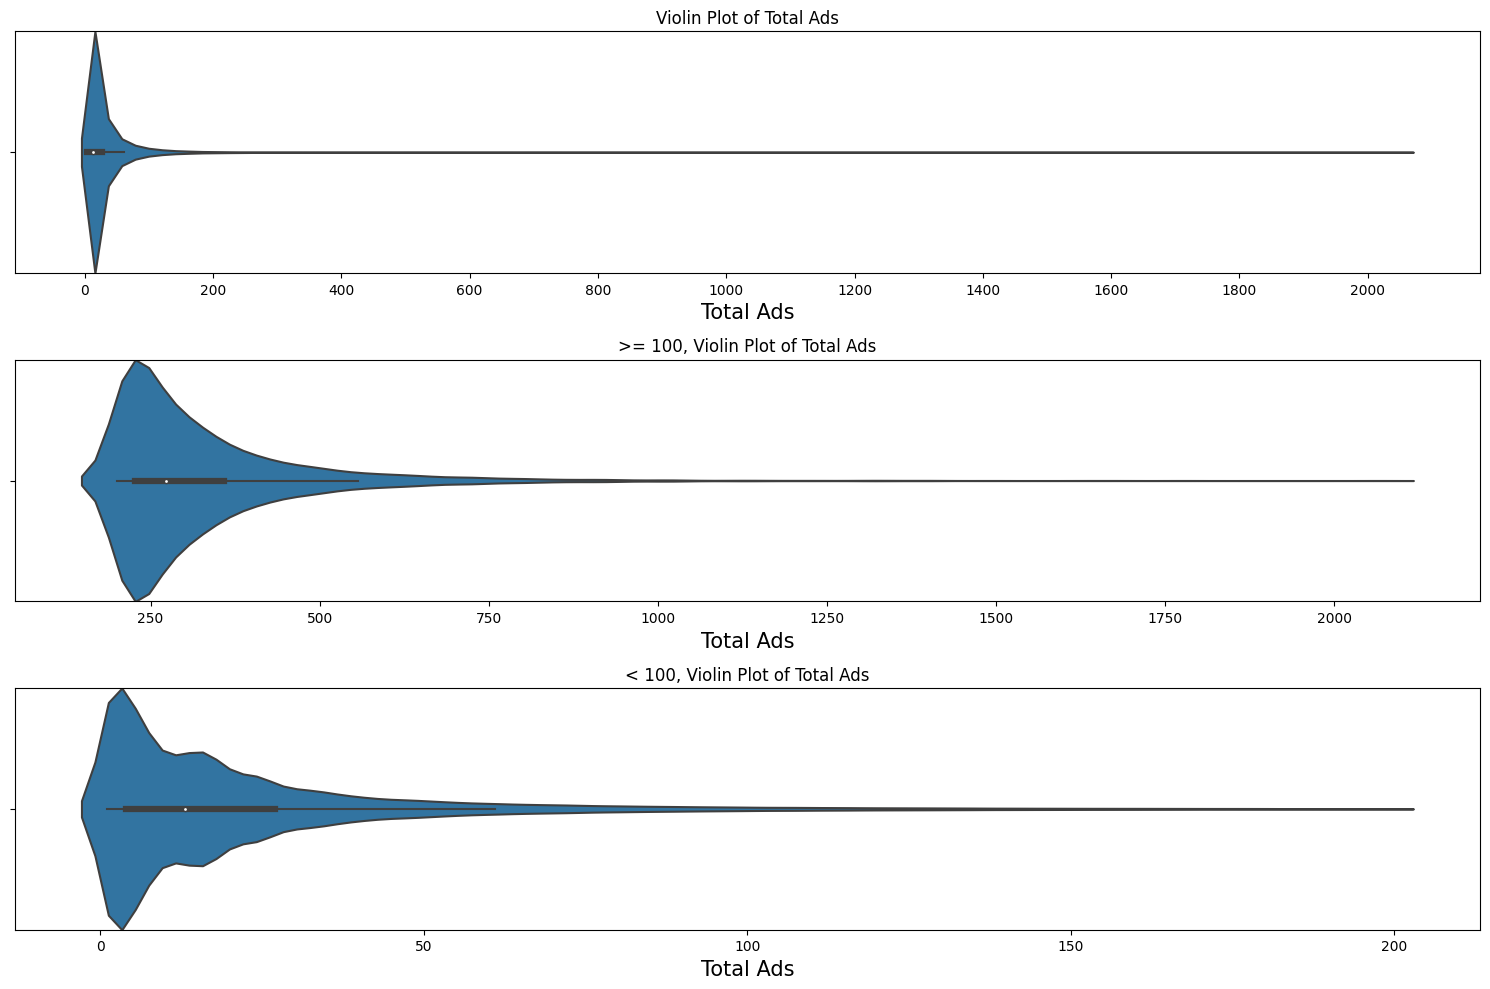

In [11]:
fig, axes = plt.subplots(3, 1, figsize = (15, 10))
sns.violinplot(x = df_original['total_ads'], orient = 'h', width = 1, ax = axes[0])
axes[0].set_title('Violin Plot of Total Ads')
axes[0].set_xlabel('Total Ads', fontsize = 15)
axes[0].set_xticks(range(0, int(df_original['total_ads'].max())  , 200)  )


filtered_total_ads = df_original['total_ads'][df_original['total_ads'] >= 200]
sns.violinplot(x = filtered_total_ads, orient = 'h', width = 1, ax = axes[1])
axes[1].set_title('>= 100, Violin Plot of Total Ads')
axes[1].set_xlabel('Total Ads', fontsize = 15)


filtered_total_ads_2 = df_original['total_ads'][df_original['total_ads'] < 200]
sns.violinplot(x = filtered_total_ads_2, orient = 'h', width = 1, ax = axes[2])
axes[2].set_title('< 100, Violin Plot of Total Ads')
axes[2].set_xlabel('Total Ads', fontsize = 15)

plt.tight_layout()
plt.show()

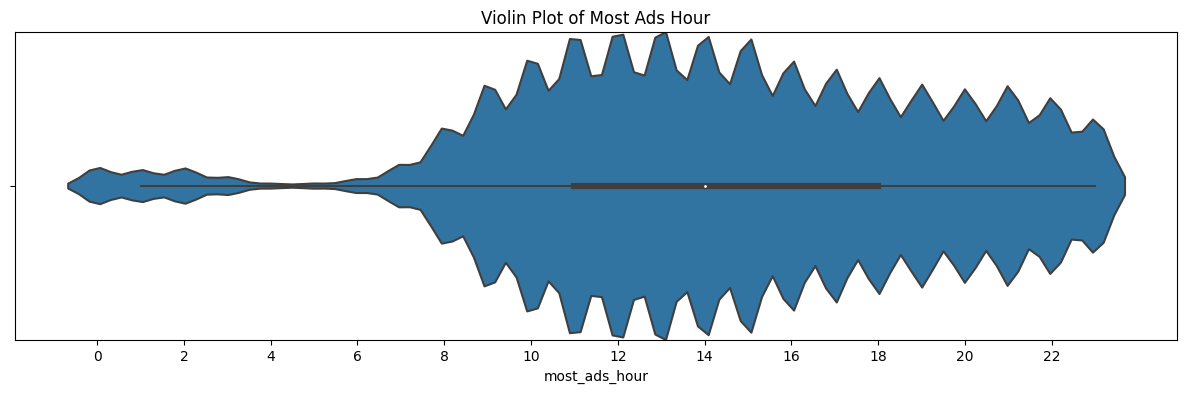

In [12]:
plt.figure(figsize = (15, 4))
sns.violinplot(x = df_original['most_ads_hour'], orient = 'h', width = 1)
plt.title('Violin Plot of Most Ads Hour')
plt.xticks(range(0, int(df_original['most_ads_hour'].max()) ,2))
plt.show()


<font size = '4'>광고 시청 시간은 주로 150시간 미만으로 머물러 있으며, 최대 2200시간까지 분포. abs
또한, 광고를 주로 시청하는 시각은 오전10시 ~ 오후 6시 사이이다.

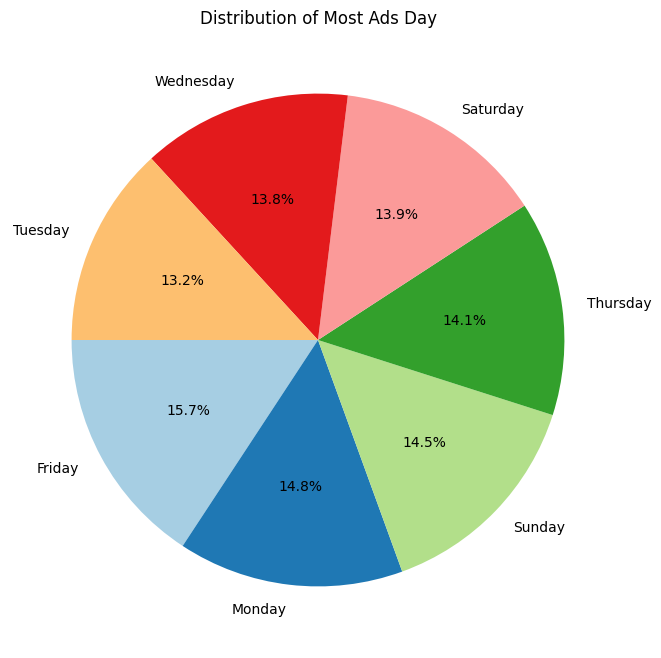

In [13]:
category_counts = df_original['most_ads_day'].value_counts()
plt.figure(figsize = (8,8))
plt.pie(category_counts, labels = category_counts.index, autopct = '%1.1f%%', 
       startangle = 180, colors = plt.cm.Paired.colors)

plt.title('Distribution of Most Ads Day')
plt.show()

<font size = '4'>요일별 분포는 고른 편</font>


In [14]:
df_filtered_1 = df_original[df_original['total_ads'] >= 200]
grouped = df_filtered_1.groupby(['test_group', 'converted']).size().reset_index(name = 'size')
grouped['sum'] = grouped.groupby('test_group')['size'].transform('sum')
grouped['prop'] = grouped['size'] / grouped['sum']
grouped['min_total_ads'] = 200 

df_filtered_5 = df_original
grouped_5 = df_filtered_5.groupby(['test_group', 'converted']).size().reset_index(name = 'size')
grouped_5['sum'] = grouped_5.groupby('test_group')['size'].transform('sum')
grouped_5['prop'] = grouped_5['size'] / grouped_5['sum']
grouped_5['min_total_ads'] = 0 
grouped = pd.concat( (grouped, grouped_5), axis = 0)


df_filtered_4 = df_original[df_original['total_ads'] >= 50]
grouped_4 = df_filtered_4.groupby(['test_group', 'converted']).size().reset_index(name = 'size')
grouped_4['sum'] = grouped_4.groupby('test_group')['size'].transform('sum')
grouped_4['prop'] = grouped_4['size'] / grouped_4['sum']
grouped_4['min_total_ads'] = 50 
grouped = pd.concat( (grouped, grouped_4), axis = 0)


df_filtered_2 = df_original[df_original['total_ads'] >= 500]
grouped_2 = df_filtered_2.groupby(['test_group', 'converted']).size().reset_index(name = 'size')
grouped_2['sum'] = grouped_2.groupby('test_group')['size'].transform('sum')
grouped_2['prop'] = grouped_2['size'] / grouped_2['sum']
grouped_2['min_total_ads'] = 500 
grouped = pd.concat( (grouped, grouped_2), axis = 0)

df_filtered_3 = df_original[df_original['total_ads'] >= 1000]
grouped_3 = df_filtered_3.groupby(['test_group', 'converted']).size().reset_index(name = 'size')
grouped_3['sum'] = grouped_3.groupby('test_group')['size'].transform('sum')
grouped_3['prop'] = grouped_3['size'] / grouped_3['sum']
grouped_3['min_total_ads'] = 1000 
grouped = pd.concat( (grouped, grouped_3), axis = 0)


grouped_converted = grouped[grouped['converted'] == True]
grouped_converted = grouped_converted.sort_values(['test_group', 'min_total_ads'], ascending = [True, True])
grouped_converted

,test_group,converted,size,sum,prop,min_total_ads
1,ad,True,14423,564577,0.025547,0
1,ad,True,9046,68148,0.132741,50
1,ad,True,894,5740,0.155749,200
1,ad,True,100,570,0.175439,500
1,ad,True,8,36,0.222222,1000
3,psa,True,420,23524,0.017854,0
3,psa,True,228,2946,0.077393,50
3,psa,True,41,261,0.157088,200
3,psa,True,2,19,0.105263,500


<font size = '4'> 실험 그룹, 통제 그룹 모두 시청 시간이 늘어날 수록 전환율 역시 늘어나는 경향

In [15]:
df_original['total_ads_bins'], bins = pd.qcut(df_original['total_ads'], q = 3, 
                                              labels = False, retbins = True)
df_original['converted'] = df_original['converted'].astype(int)

bins = bins.astype(int)
df_s = df_original[df_original['total_ads_bins'] == 0]
df_m = df_original[df_original['total_ads_bins'] == 1]
df_l = df_original[df_original['total_ads_bins'] == 2]
print(bins)

df_l.loc[:, 'total_ads_bins'], bins = pd.qcut(df_l['total_ads'], q=4, labels=False, retbins=True)
print(bins)
df_xl = df_l[df_l['total_ads_bins'] == 3]
df_l = df_l.loc[df_l['total_ads_bins'].isin([0, 1, 2])]


[   1    6   21 2065]
[  22.   28.   39.   65. 2065.]


In [16]:
from statsmodels.stats.proportion import proportions_ztest

def z_test_for_conversion(df, df_name):
    ad_converted_cnt = df[ (df['test_group'] == 'ad') & (df['converted'] == 1)].shape[0]
    ad_total_nob = df[ df['test_group'] == 'ad' ].shape[0]
    psa_converted_cnt = df[(df['test_group'] == 'psa') & (df['converted'] == 1)].shape[0]
    psa_total_nob = df[df['test_group'] == 'psa'].shape[0]    

    counts = [ad_converted_cnt, psa_converted_cnt]  
    nobs = [ad_total_nob, psa_total_nob] 
    length = len(df)

    z_stat, p_value = proportions_ztest(count = counts, nobs = nobs, alternative = 'larger')
    print(f"Z-statistic: {z_stat:.4f}, P-value : {p_value:.4f} ")
    print('전체 표본 수 : {}, 광고시청시간 범위 :{}시간 이상 {}이하'.\
          format(length, df['total_ads'].min(), df['total_ads'].max()))
    if ad_converted_cnt < 5 or psa_converted_cnt < 5:
        print(f'표본 수 부족! 실헙그룹 convert 표본 수: {ad_converted_cnt}, 통제그룹 convert 표본 수: {psa_converted_cnt}')
    else:
        print(f'실헙그룹 convert 비율: {(ad_converted_cnt/ad_total_nob):.2f}, \
        통제그룹 convert 비율: {(psa_converted_cnt/psa_total_nob):.2f}')
    if p_value < 0.05:
        print(f"O: {df_name}의 경우, p_value 0.05 기준으로 통계적으로 유의미한 광고 효과가 있습니다")
    else:
        print(f"X : {df_name}의 경우, p_value 0.05 기준으로 통계적으로 유의미한 광고 효과가 없습니다")
    print('-'*80)
        
z_test_for_conversion(df_s, 'df_s')
z_test_for_conversion(df_m, 'df_m')
z_test_for_conversion(df_l, 'df_l')
z_test_for_conversion(df_xl, 'df_xl')

Z-statistic: -0.8221, P-value : 0.7945 
전체 표본 수 : 201232, 광고시청시간 범위 :1시간 이상 6이하
실헙그룹 convert 비율: 0.00,         통제그룹 convert 비율: 0.00
X : df_s의 경우, p_value 0.05 기준으로 통계적으로 유의미한 광고 효과가 없습니다
--------------------------------------------------------------------------------
Z-statistic: -0.1213, P-value : 0.5483 
전체 표본 수 : 195410, 광고시청시간 범위 :7시간 이상 21이하
실헙그룹 convert 비율: 0.01,         통제그룹 convert 비율: 0.01
X : df_m의 경우, p_value 0.05 기준으로 통계적으로 유의미한 광고 효과가 없습니다
--------------------------------------------------------------------------------
Z-statistic: 4.8245, P-value : 0.0000 
전체 표본 수 : 144039, 광고시청시간 범위 :22시간 이상 65이하
실헙그룹 convert 비율: 0.04,         통제그룹 convert 비율: 0.03
O: df_l의 경우, p_value 0.05 기준으로 통계적으로 유의미한 광고 효과가 있습니다
--------------------------------------------------------------------------------
Z-statistic: 7.7734, P-value : 0.0000 
전체 표본 수 : 47420, 광고시청시간 범위 :66시간 이상 2065이하
실헙그룹 convert 비율: 0.16,         통제그룹 convert 비율: 0.09
O: df_xl의 경우, p_value 0.05 기준으로 통계적으로 유의미한 광고 효과가 있습니다
--

In [17]:
df_l.loc[:, 'total_ads_bins'], bins = pd.qcut(df_l['total_ads'],  q = 16, labels = False, retbins = True)

df_l1 = df_l[df_l['total_ads_bins'] == 9]
df_l2 = df_l[df_l['total_ads_bins'] == 10]
df_l3 = df_l[df_l['total_ads_bins'] == 11]
df_l4 = df_l[df_l['total_ads_bins'] == 12]
df_l5 = df_l[df_l['total_ads_bins'] == 13]
df_l6 = df_l[df_l['total_ads_bins'] == 14]

z_test_for_conversion(df_l1, 'df_xl')
z_test_for_conversion(df_l2, 'df_xl')
z_test_for_conversion(df_l3, 'df_xl')
z_test_for_conversion(df_l4, 'df_xl')
z_test_for_conversion(df_l5, 'df_xl')
z_test_for_conversion(df_l6, 'df_xl')

Z-statistic: 1.3890, P-value : 0.0824 
전체 표본 수 : 10463, 광고시청시간 범위 :36시간 이상 38이하
실헙그룹 convert 비율: 0.04,         통제그룹 convert 비율: 0.02
X : df_xl의 경우, p_value 0.05 기준으로 통계적으로 유의미한 광고 효과가 없습니다
--------------------------------------------------------------------------------
Z-statistic: -0.3869, P-value : 0.6506 
전체 표본 수 : 5954, 광고시청시간 범위 :39시간 이상 40이하
실헙그룹 convert 비율: 0.04,         통제그룹 convert 비율: 0.05
X : df_xl의 경우, p_value 0.05 기준으로 통계적으로 유의미한 광고 효과가 없습니다
--------------------------------------------------------------------------------
Z-statistic: 0.5918, P-value : 0.2770 
전체 표본 수 : 10151, 광고시청시간 범위 :41시간 이상 44이하
실헙그룹 convert 비율: 0.05,         통제그룹 convert 비율: 0.04
X : df_xl의 경우, p_value 0.05 기준으로 통계적으로 유의미한 광고 효과가 없습니다
--------------------------------------------------------------------------------
Z-statistic: 2.4695, P-value : 0.0068 
전체 표본 수 : 8959, 광고시청시간 범위 :45시간 이상 48이하
실헙그룹 convert 비율: 0.06,         통제그룹 convert 비율: 0.03
O: df_xl의 경우, p_value 0.05 기준으로 통계적으로 유의미한 광고 효과가 있습니다
---

<font size = '4'>*통제그룹의 convert 표본 수가 최소 5 이상이어야 통계적으로 유의미한데, 저기서 광고 시청시간 범위를 더 세분화 시킬 경우 표본 수가 부족해 지기에 현재 세분화 수준에서 멈추도록 한다*

<h3>**분석 결과, 광고 시청 시간 45시간 이상부터 통제그룹과 실험그룹 간의 전환율에 통계적으로 유의미한 차이가 (p_value <= 0.05)을 보이기 시작하였으며, 이는 이 시점부터 광고의 효과가 나타난다는 것을 시사한다.**</h3>

<font size = '4'>또한, 이후 요일, 시간대별 광고 효과를 분석할 때, 두 가지 그룹으로 나누어 분석을 실시한다.
첫 번째 그룹 : 광고 시청 시간 45시간 이상인 그룹. 광고효과가 통계적으로 입증된 그룹이다.
두 번째 그룹 : 전체 데이터를 대상으로 한 그룹이다.

<font size = '4'>만약 첫 번째 그룹과 다른 분석 결과가 나온다면 45시간 미만인 그룹을 별도로 분석하여 그 원인을 검토하도록 한다

In [18]:
df_original

,user id,test_group,converted,total_ads,most_ads_day,most_ads_hour,total_ads_bins
0,1069124,ad,0,130,Monday,20,2
1,1119715,ad,0,93,Tuesday,22,2
2,1144181,ad,0,21,Tuesday,18,1
3,1435133,ad,0,355,Tuesday,10,2
4,1015700,ad,0,276,Friday,14,2
...,...,...,...,...,...,...,...
588096,1278437,ad,0,1,Tuesday,23,0
588097,1327975,ad,0,1,Tuesday,23,0
588098,1038442,ad,0,3,Tuesday,23,0
588099,1496395,ad,0,1,Tuesday,23,0


In [19]:
df_effective = df_original[df_original['total_ads'] >= 45]
len(df_effective)

82056

In [20]:
def cohens_h(p1, p2):
    return 2 * ( np.arcsin(np.sqrt(p1))  - np.arcsin(np.sqrt(p2))    )

def find_effective(df, col):
    ad_group = df[df['test_group'] == 'ad']
    psa_group = df[df['test_group'] == 'psa']
    groupby_day_ad = ad_group.groupby(col)['converted'].agg(['sum', 'count'])
    groupby_day_psa = psa_group.groupby(col)['converted'].agg(['sum', 'count'])
    
    for day in groupby_day_ad.index:
        ad_converted = groupby_day_ad.loc[day, 'sum']
        ad_total = groupby_day_ad.loc[day, 'count']
        psa_converted = groupby_day_psa.loc[day, 'sum']
        psa_total = groupby_day_psa.loc[day, 'count']
    
        counts = [ad_converted, psa_converted]
        nobs = [ad_total, psa_total]
        z_stat, p_value = proportions_ztest(count = counts, nobs = nobs, alternative = 'larger')
    
        ad_rate = ad_converted / ad_total
        psa_rate = psa_converted / psa_total
    
        h_value = cohens_h(ad_rate, psa_rate)
        rate_diff = ad_rate - psa_rate
        
        print(f'{day} - Z-Statistic : {z_stat:.4f}, P-value : {p_value:.4f}')
        if p_value < 0.05:
            print('해당 요일은 통계적으로 유의미한 광고 효과가 있습니다.')
            print(f"cohen's h 값 : {h_value:.2f}, 변환율 차이 : {rate_diff:.2f} ")
        else:
            print("→ 해당 요일은 통계적으로 유의미한 광고 효과가 없습니다.")
        print('-'*50)

find_effective(df_effective, 'most_ads_day')

Friday - Z-Statistic : 2.3423, P-value : 0.0096
해당 요일은 통계적으로 유의미한 광고 효과가 있습니다.
cohen's h 값 : 0.11, 변환율 차이 : 0.03 
--------------------------------------------------
Monday - Z-Statistic : 3.2749, P-value : 0.0005
해당 요일은 통계적으로 유의미한 광고 효과가 있습니다.
cohen's h 값 : 0.17, 변환율 차이 : 0.06 
--------------------------------------------------
Saturday - Z-Statistic : 3.9561, P-value : 0.0000
해당 요일은 통계적으로 유의미한 광고 효과가 있습니다.
cohen's h 값 : 0.21, 변환율 차이 : 0.05 
--------------------------------------------------
Sunday - Z-Statistic : 2.8676, P-value : 0.0021
해당 요일은 통계적으로 유의미한 광고 효과가 있습니다.
cohen's h 값 : 0.15, 변환율 차이 : 0.04 
--------------------------------------------------
Thursday - Z-Statistic : 3.5885, P-value : 0.0002
해당 요일은 통계적으로 유의미한 광고 효과가 있습니다.
cohen's h 값 : 0.17, 변환율 차이 : 0.05 
--------------------------------------------------
Tuesday - Z-Statistic : 4.0723, P-value : 0.0000
해당 요일은 통계적으로 유의미한 광고 효과가 있습니다.
cohen's h 값 : 0.25, 변환율 차이 : 0.08 
--------------------------------------------------
Wedne

In [21]:
find_effective(df_original, 'most_ads_day')

Friday - Z-Statistic : 2.5250, P-value : 0.0058
해당 요일은 통계적으로 유의미한 광고 효과가 있습니다.
cohen's h 값 : 0.04, 변환율 차이 : 0.01 
--------------------------------------------------
Monday - Z-Statistic : 3.4766, P-value : 0.0003
해당 요일은 통계적으로 유의미한 광고 효과가 있습니다.
cohen's h 값 : 0.07, 변환율 차이 : 0.01 
--------------------------------------------------
Saturday - Z-Statistic : 2.6745, P-value : 0.0037
해당 요일은 통계적으로 유의미한 광고 효과가 있습니다.
cohen's h 값 : 0.06, 변환율 차이 : 0.01 
--------------------------------------------------
Sunday - Z-Statistic : 1.4146, P-value : 0.0786
→ 해당 요일은 통계적으로 유의미한 광고 효과가 없습니다.
--------------------------------------------------
Thursday - Z-Statistic : 0.5907, P-value : 0.2774
→ 해당 요일은 통계적으로 유의미한 광고 효과가 없습니다.
--------------------------------------------------
Tuesday - Z-Statistic : 4.9718, P-value : 0.0000
해당 요일은 통계적으로 유의미한 광고 효과가 있습니다.
cohen's h 값 : 0.11, 변환율 차이 : 0.02 
--------------------------------------------------
Wednesday - Z-Statistic : 3.5561, P-value : 0.0002
해당 요일은 통계적으로 유의미한 광고

<font size = '4'>광고효과가 있는 45시간 이상의 그룹에선 변환율이 3 ~ 8% 사이로 비교적 큰 편. 반면 전체적으로 보면 1~2% 차이로 크진 않다. 한편, cohen's h 값이 0.5가 넘는 요일이 없기에 좀 더 세부적으로 분석할 필요가 있다

In [22]:
bins = [int(i) for i in np.linspace( df_effective['most_ads_hour'].min(),
                                    df_effective['most_ads_hour'].max()+1, 13)]
labels = [ f'{bins[i]}~{int(bins[i+1]) -1}' for i in range(len(bins)-1)  ]
df_effective.loc[:, 'most_ads_bins'] = pd.cut(df_effective['most_ads_hour'], labels = labels,
                                       bins = bins, right = False, include_lowest= True )

def find_effective_hrs(df, col):
    ad_group = df[df['test_group'] == 'ad']
    psa_group = df[df['test_group'] == 'psa']
    groupby_day_ad = ad_group.groupby(col, observed = False)['converted'].agg(['sum', 'count'])
    groupby_day_psa = psa_group.groupby(col, observed = False)['converted'].agg(['sum', 'count'])
    
    for day in groupby_day_ad.index:
        ad_converted = groupby_day_ad.loc[day, 'sum']
        ad_total = groupby_day_ad.loc[day, 'count']
        psa_converted = groupby_day_psa.loc[day, 'sum']
        psa_total = groupby_day_psa.loc[day, 'count']
    
        counts = [ad_converted, psa_converted]
        nobs = [ad_total, psa_total]
        z_stat, p_value = proportions_ztest(count = counts, nobs = nobs, alternative = 'larger')
    
        ad_rate = ad_converted / ad_total
        psa_rate = psa_converted / psa_total
    
        h_value = cohens_h(ad_rate, psa_rate)
        rate_diff = ad_rate - psa_rate
        
        se = np.sqrt(( (ad_rate * (1 - ad_rate)) / ad_total ) + ( (psa_rate * (1 - psa_rate)) / psa_total ) )
        z_value = 1.96  

        ci_lower = rate_diff - z_value * se
        ci_upper = rate_diff + z_value * se

        if (p_value < 0.05) & (psa_converted >= 5):
            print(f'{day} - Z-Statistic : {z_stat:.4f}, P-value : {p_value:.4f}')
            print(f'PSA convert 표본 수: {psa_converted}, AD convert 표본 수 : {ad_converted}')
            print('해당 시간대는 통계적으로 유의미한 광고 효과가 있습니다.')
            print(f"cohen's h 값 : {h_value:.2f}, 변환율 차이 : {rate_diff:.2f}, (95% CI: [{ci_lower:.2f}, {ci_upper:.2f}])")
            print('-'*50)


find_effective_hrs(df_effective, 'most_ads_bins')

8~9 - Z-Statistic : 3.5449, P-value : 0.0002
PSA convert 표본 수: 10, AD convert 표본 수 : 643
해당 시간대는 통계적으로 유의미한 광고 효과가 있습니다.
cohen's h 값 : 0.27, 변환율 차이 : 0.07, (95% CI: [0.04, 0.09])
--------------------------------------------------
10~11 - Z-Statistic : 4.1435, P-value : 0.0000
PSA convert 표본 수: 24, AD convert 표본 수 : 1222
해당 시간대는 통계적으로 유의미한 광고 효과가 있습니다.
cohen's h 값 : 0.23, 변환율 차이 : 0.06, (95% CI: [0.04, 0.08])
--------------------------------------------------
12~13 - Z-Statistic : 3.5969, P-value : 0.0002
PSA convert 표본 수: 44, AD convert 표본 수 : 1537
해당 시간대는 통계적으로 유의미한 광고 효과가 있습니다.
cohen's h 값 : 0.16, 변환율 차이 : 0.05, (95% CI: [0.03, 0.07])
--------------------------------------------------
14~15 - Z-Statistic : 3.2826, P-value : 0.0005
PSA convert 표본 수: 50, AD convert 표본 수 : 1735
해당 시간대는 통계적으로 유의미한 광고 효과가 있습니다.
cohen's h 값 : 0.16, 변환율 차이 : 0.05, (95% CI: [0.03, 0.08])
--------------------------------------------------
16~17 - Z-Statistic : 3.3123, P-value : 0.0005
PSA convert 표본 수: 34, AD

/tmp/ipykernel_24/1388681949.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_effective.loc[:, 'most_ads_bins'] = pd.cut(df_effective['most_ads_hour'], labels = labels,


In [23]:
def find_effective_hrs(df, col1, col2, num):
    bins = [int(i) for i in np.linspace( df_effective['most_ads_hour'].min(),
                                    df_effective['most_ads_hour'].max()+1, num)]
    labels = [ f'{bins[i]}~{bins[i+1] -1}' for i in range(len(bins)-1)  ]
    df_effective.loc[:, 'most_ads_bins'] = pd.cut(df_effective['most_ads_hour'], labels = labels,
                                           bins = bins, right = False, include_lowest= True ).astype('category')
    ad_group = df[df['test_group'] == 'ad']
    psa_group = df[df['test_group'] == 'psa']
    groupby_day_ad = ad_group.groupby([col1, col2], observed = False)['converted'].agg(['sum', 'count'])
    groupby_day_psa = psa_group.groupby([col1, col2], observed = False)['converted'].agg(['sum', 'count'])
    
    for day in groupby_day_ad.index:
        ad_converted = groupby_day_ad.loc[day, 'sum']
        ad_total = groupby_day_ad.loc[day, 'count']
        psa_converted = groupby_day_psa.loc[day, 'sum']
        psa_total = groupby_day_psa.loc[day, 'count']
        
        if psa_total == 0 or ad_total == 0:
            continue
            
        counts = [ad_converted, psa_converted]
        nobs = [ad_total, psa_total]
        z_stat, p_value = proportions_ztest(count = counts, nobs = nobs, alternative = 'larger')
    
        ad_rate = ad_converted / ad_total
        psa_rate = psa_converted / psa_total
    
        h_value = cohens_h(ad_rate, psa_rate)
        rate_diff = ad_rate - psa_rate

        se = np.sqrt(( (ad_rate * (1 - ad_rate)) / ad_total ) + ( (psa_rate * (1 - psa_rate)) / psa_total ) )
        z_value = 1.96  


        ci_lower = rate_diff - z_value * se
        ci_upper = rate_diff + z_value * se
 
        if (p_value < 0.05) & (ci_lower >= 0.04) & (psa_converted >=5):
            print(f'{day} - Z-Statistic : {z_stat:.4f}, P-value : {p_value:.4f}')
            print(f'PSA 표본 수: {psa_total}, PSA Converted 수 : {psa_converted}')
            print(f"cohen's h 값 : {h_value:.2f}, 변환율 차이 : {rate_diff:.2f}, (95% CI: [{ci_lower:.2f}, {ci_upper:.2f}])")

            print('-'*50)

find_effective_hrs(df_effective, 'most_ads_day','most_ads_bins', 9)

('Tuesday', '12~14') - Z-Statistic : 2.8683, P-value : 0.0021
PSA 표본 수: 109, PSA Converted 수 : 7
cohen's h 값 : 0.33, 변환율 차이 : 0.10, (95% CI: [0.06, 0.15])
--------------------------------------------------
('Tuesday', '15~17') - Z-Statistic : 2.3883, P-value : 0.0085
PSA 표본 수: 65, PSA Converted 수 : 5
cohen's h 값 : 0.35, 변환율 차이 : 0.12, (95% CI: [0.05, 0.19])
--------------------------------------------------


/tmp/ipykernel_24/3445955322.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['18~20', '21~23', '9~11', '12~14', '9~11', ..., '12~14', '9~11', '12~14', '12~14', '12~14']
Length: 82056
Categories (8, object): ['0~2' < '3~5' < '6~8' < '9~11' < '12~14' < '15~17' < '18~20' < '21~23']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  df_effective.loc[:, 'most_ads_bins'] = pd.cut(df_effective['most_ads_hour'], labels = labels,


In [24]:
find_effective_hrs(df_effective, 'most_ads_day','most_ads_bins', 7)

('Saturday', '16~19') - Z-Statistic : 2.7916, P-value : 0.0026
PSA 표본 수: 126, PSA Converted 수 : 5
cohen's h 값 : 0.31, 변환율 차이 : 0.08, (95% CI: [0.05, 0.12])
--------------------------------------------------
('Tuesday', '12~15') - Z-Statistic : 3.4306, P-value : 0.0003
PSA 표본 수: 143, PSA Converted 수 : 9
cohen's h 값 : 0.35, 변환율 차이 : 0.11, (95% CI: [0.07, 0.15])
--------------------------------------------------


/tmp/ipykernel_24/3445955322.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['20~23', '20~23', '8~11', '12~15', '8~11', ..., '12~15', '8~11', '12~15', '12~15', '12~15']
Length: 82056
Categories (6, object): ['0~3' < '4~7' < '8~11' < '12~15' < '16~19' < '20~23']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  df_effective.loc[:, 'most_ads_bins'] = pd.cut(df_effective['most_ads_hour'], labels = labels,


<font size = '4'> 화요일 오후 12 ~ 17시, 토요일 오후 4~7시가 표본이 충분하며 변환율이 10% 전후로 큰편이다

In [25]:
df_effective.loc[:,'ads_bins'] = pd.qcut(df_effective['total_ads'], q = 10)
df_effective

/tmp/ipykernel_24/1296426607.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_effective.loc[:,'ads_bins'] = pd.qcut(df_effective['total_ads'], q = 10)


,user id,test_group,converted,total_ads,most_ads_day,most_ads_hour,total_ads_bins,most_ads_bins,ads_bins
0,1069124,ad,0,130,Monday,20,2,20~23,"(121.0, 172.0]"
1,1119715,ad,0,93,Tuesday,22,2,20~23,"(82.0, 97.0]"
3,1435133,ad,0,355,Tuesday,10,2,8~11,"(172.0, 2065.0]"
4,1015700,ad,0,276,Friday,14,2,12~15,"(172.0, 2065.0]"
5,1137664,ad,0,734,Saturday,10,2,8~11,"(172.0, 2065.0]"
...,...,...,...,...,...,...,...,...,...
551179,1495479,ad,0,50,Tuesday,12,2,12~15,"(48.0, 52.0]"
551271,1447680,ad,1,49,Tuesday,11,2,8~11,"(48.0, 52.0]"
551594,1203942,ad,0,48,Tuesday,12,2,12~15,"(44.999, 48.0]"
552011,1564103,ad,0,52,Tuesday,13,2,12~15,"(48.0, 52.0]"


(광고 시간 당 비용 : 0.03$, Conversion 당 수익 : 25$ 기준) :
최적의 광고 시청 시간 구간은 82.0 ~ 97.0 시간입니다



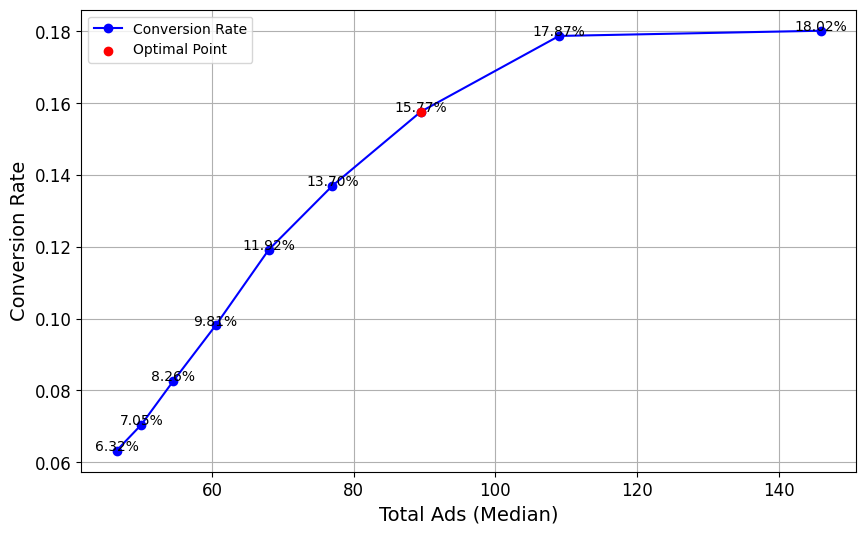

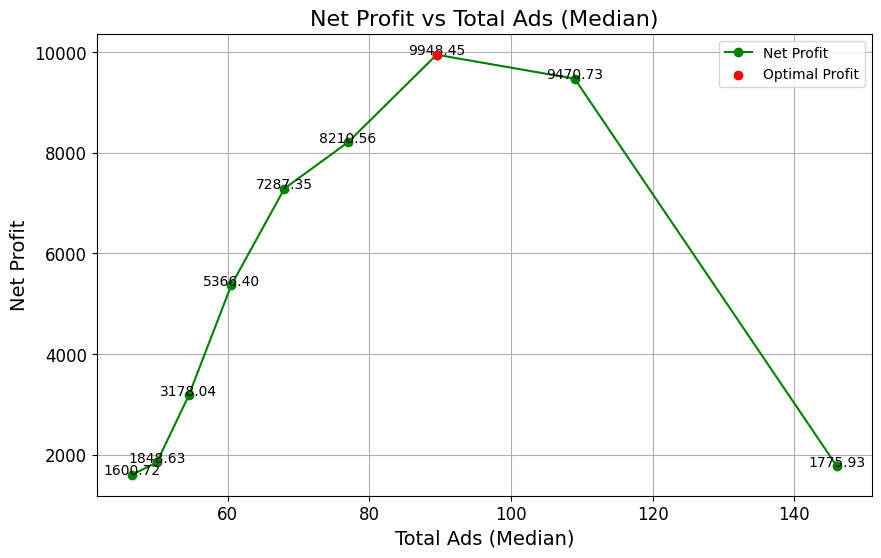

In [26]:
def optimal_ads_hours(df, cost = 0.01, revenue = 30, bins = 10):
    ad_group = df[df['test_group'] == 'ad'].copy()
    ad_group['ads_bins'] = pd.qcut(ad_group['total_ads'], q = bins)
    grouped= ad_group.groupby('ads_bins', observed = True).agg(
        total_ads = ('total_ads', 'sum'),
        total_customers = ('converted', 'size'),
        converted = ('converted', 'sum')
    ).reset_index()

    grouped['conversion_rate'] = grouped['converted'] / grouped['total_customers']
    grouped['ad_cost'] = grouped['total_ads'] * cost
    grouped['ad_revenue'] = grouped['converted'] * revenue
    grouped['net_profit'] = grouped['ad_revenue'] - grouped['ad_cost']
    grouped['ads_median'] = grouped['ads_bins'].apply(lambda x: (x.left + x.right) / 2)
    grouped = grouped.iloc[:-1]
    
    optimal_bin = grouped.loc[grouped['net_profit'].idxmax()]
    optimal_time = optimal_bin['ads_bins']
    left = optimal_time.left
    right = optimal_time.right
    optimal_median = optimal_bin['ads_median']
    
    print(f'(광고 시간 당 비용 : {cost}$, Conversion 당 수익 : {revenue}$ 기준) :')
    print(f"\033[1m최적의 광고 시청 시간 구간은 {left} ~ {right} 시간입니다\033[0m\n")

    

    plt.figure(figsize=(10, 6))
    plt.plot(grouped['ads_median'], grouped['conversion_rate'], marker = 'o', linestyle = '-', color = 'b', label = 'Conversion Rate')
    plt.scatter(optimal_median, optimal_bin['conversion_rate'], color = 'red', label = 'Optimal Point', zorder = 5)
    plt.xlabel('Total Ads (Median)', fontsize=14)
    plt.ylabel('Conversion Rate', fontsize=14)
    plt.grid(True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend()
    
    for x, y in zip(grouped['ads_median'], grouped['conversion_rate']):
        plt.text(x, y, f'{y:.2%}', fontsize=10, ha='center')
    
    plt.show()
    

    plt.figure(figsize=(10, 6))
    plt.plot(grouped['ads_median'], grouped['net_profit'], marker='o', linestyle='-', color='g', label='Net Profit')
    plt.scatter(optimal_median, optimal_bin['net_profit'], color='red', label='Optimal Profit', zorder=5)
    plt.title('Net Profit vs Total Ads (Median)', fontsize=16)
    plt.xlabel('Total Ads (Median)', fontsize=14)
    plt.ylabel('Net Profit', fontsize=14)
    plt.grid(True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend()
    
    
    for x, y in zip(grouped['ads_median'], grouped['net_profit']):
        plt.text(x, y, f'{y:.2f}', fontsize=10, ha='center')
    
    plt.show()
    
    return grouped, optimal_bin, optimal_time

result, optimal_bin, optimal_time = optimal_ads_hours(
    df_effective, cost=0.03, revenue=25, bins=10
)


<font size = '4'> 시청 시간 별로 10구간으로 나누었을 때, 시청 시간이 늘어날 수록 전환율 역시 올라간다 (단, 마지막 구간은 2200시간까지가 구간으로 편차가 크기에 제외) <br>
광고 시간 당 비용과 수익을 각각 0.03달러, 25달러로 가정 시, 
수익을 극대화할 수 있는 최적의 광고 시간은 82~97시간 사이이다.



### 최종 요약

#### 목적: 
본 A/B 테스트 분석은 광고 캠페인의 효과를 평가하고, 
이를 통해 전환율 향상과 수익 극대화를 위한 최적의 광고 전략을 도출하는 데 목적이 있습니다.

#### 검정 방법:

1. t-검정을 통해 광고 그룹(실험 그룹)과 공익광고 그룹(통제 그룹) 간의 전환율 차이를 분석하였습니다.
2. Cohen's h 값 및 t-검정을 사용하여 요일별, 시간대별 전환율 차이를 평가하였습니다.
3. 시간당 광고 비용(0.3달러/시간)과 전환당 수익(25달러)을 기반으로 최적의 광고 시간을 추정하였습니다.

#### 결과:
    
1. 광고 효과 : 광고 시청 시간이 45시간 이상일 때 광고 그룹과 공익광고 그룹 간 전환율 차이가 
    통계적으로 유의미한 것으로 나타났습니다 (p-value < 0.05).
2. 전환율 증가 : **45시간에서 전환율 3%**로 시작해, 선형적으로 증가하여 최대 **9%**까지 상승.
    광고 시청 시간당 전환율 상승률은 45시간부터 110시간까지 약 0.17%/시간으로 나타났습니다. 110시간 이후에는 유의미한 상승 효과가 관찰되지 않았습니다.
3. 요일별 전환율 : 화요일의 전환율이 **8%**로 가장 높은 결과를 보였습니다.
4. 시간대별 전환율: 오전 8~9시가 평균 전환율 **7%**로 가장 효과적인 시간대로 나타났습니다.
5. 요일 + 시간대 조합: 화요일 오후 12 ~ 17시의 전환율이 **10~12%**로 가장 높은 성과를 기록했습니다
6. 최적 광고 시간: 광고 비용 0.3달러/시간, 전환당 수익 25달러 기준으로, 최적의 광고 시간은 82~97시간으로 계산되었습니다.


### 광고 전략 도출:
1. **최적 광고 노출 시간**:
    - 광고 효과를 보기 위해 최소한 45시간 이상 노출해야 합니다.
    - 광고 비용이 크다면 45~70시간 구간에서 집중적으로 노출하는 것이 가장 효율적입니다.
    - 광고 효과가 감소하기 시작하는 110시간을 초과하지 않는 것이 권장됩니다.

2. **시간대 및 요일별 전략**:
   - 요일별 전략:
    광고는 화요일에 집중적으로 배포하는 것이 가장 효과적이며, 금요일은 피하는 것이 좋습니다.
   - 시간대별 전략:
    아침 8~9시에 광고하는 것이 효과적이며, 오후 8시 이후 자정까지는 광고를 피해야 합니다.
   - 요일 + 시간대 최적화:
    화요일 오후 12~17시가 광고 효과가 가장 뛰어난 시간대로 나타났습니다.

    
3. **수익성**:
   - 광고 비용 대비 전환 수익이 낮을 경우, 광고 노출 시간을 70시간 선에서 제한하는 것이 효과적입니다.
   - 비용 대비 전환 수익이 높을 경우, 110시간 미만을 목표로 설정하여 수익을 극대화하는 것이 바람직합니다.

#### 데이터 한계:

1. 표본 수 부족:
특정 요일 및 시간대의 데이터가 부족하여 t-검정의 가정(𝑛×𝑝≥5)이 충족되지 않았습니다. 이로 인해 일부 요일+시간대는 분석에서 제외되었습니다.

2. 신뢰구간의 변동성:
표본 수 부족으로 인해 95% 신뢰구간을 기반으로 집계된 평균 값에 약 **±5~7%**의 변동성이 발생하였습니다. 이는 일부 결과의 해석에 있어 불확실성을 야기할 수 있습니다.


따라서, 데이터 샘플을 확장하거나 특정 요일 및 시간대의 데이터를 보완하는 것이 필요합니다. 이를 통해 결과의 신뢰성과 해석력을 높일 수 있습니다.
